# Project Overview
## Data source
This dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/tanshihjen/clinical-gliomagrading)

## Data description
This dataset, derived from the Cancer Genome Atlas (TCGA) Project which is funded by the National Cancer Institute (NCI), is focused on the classification of glioma.  Glioma is the most prevalent type of brain tumor.  The gliomas are graded as Lower-Grade Gliomas (LGG) and Glioblastoma Multiforme (GBM).  Additionally, the LGG gliomas are further sub-classed with a Primary Diagnosis.  The grading is based on histological and imaging criteria.

The dataset includes records for a set of patients and includes demographic and mutated gene information for each patient.

## Project goal
The goal of the dataset and this project is to develop a machine learning model that can utilize the demographic and mutated gene information to predict the grading of the glioma as well as the sub-classed primary diagnosis.

## Accessing data and initial view

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
import itertools
from collections import Counter
import time
from tabulate import tabulate

In [46]:
df_csv = pd.read_csv("glioma_TCGA_GBM_LGG_Mutations_all.csv")
df = df_csv.sample(len(df_csv))

In [47]:
print(df.head())
print(df.info())

    Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
444   LGG  TCGA-LGG  TCGA-HT-7608    Male   61 years 22 days   
316   LGG  TCGA-LGG  TCGA-S9-A7J3  Female   52 years 63 days   
415   LGG  TCGA-LGG  TCGA-HW-8322    Male  39 years 304 days   
6     LGG  TCGA-LGG  TCGA-P5-A5F4  Female   35 years 68 days   
382   LGG  TCGA-LGG  TCGA-F6-A8O3    Male  34 years 160 days   

                 Primary_Diagnosis                       Race     IDH1  \
444                   Mixed glioma  black or african american  MUTATED   
316  Oligodendroglioma, anaplastic                      white  MUTATED   
415         Oligodendroglioma, NOS                      white  MUTATED   
6    Oligodendroglioma, anaplastic                      white  MUTATED   
382         Oligodendroglioma, NOS                      asian  MUTATED   

            TP53         ATRX  ...        FUBP1          RB1       NOTCH1  \
444  NOT_MUTATED  NOT_MUTATED  ...      MUTATED  NOT_MUTATED  NOT_MUTATED   
316  NOT_MUTATED

# Exploratory Data Analysis

## Missing data and bad values
The dataset has 826 patients (samples) and 26 columns.  Of the 26 columns, 20 are mutated gene indicators.

There are no missing values that need to be addressed.

The Age_at_diagnosis feature is formed as a string with years and days such as "5 years 172 days".  Five samples have a placeholder string '--' for the Age_at_diagnosis and these are removed.

In [48]:
# Check for missing values (NaNs)
print("Data has", df.isna().sum().sum(), "NaNs")
# Drop rows with invalid Age string
print(len(df[df.Age_at_diagnosis == '--']), "rows have invalid values")
df.drop(df[df.Age_at_diagnosis == '--'].index, inplace=True)
df_LGG = df.drop(df[df.Grade == 'GBM'].index).copy()

# Use only the LGG data
useOnlyLGG = False
if useOnlyLGG == True:
    df = df_LGG

Data has 0 NaNs
5 rows have invalid values


## Labeling Data
The Grade and Primary Diagnosis columns can be treated as labels where Grade is LGG or GBM.  Within the LGG graded samples, there are five Primary Diagnoses.  These columns are converted to category types to be used for evaluating the models later.  These columns are also separated from the rest so that the remaining columns can be treated as the X data frame in modeling.

In [49]:
df_labels = df[['Grade', 'Primary_Diagnosis']].copy()
df_labels['Grade'] = df_labels['Grade'].astype('category')
df_labels['gradeID'] = df_labels['Grade'].cat.codes
grade_dict = dict(enumerate(df_labels['Grade'].cat.categories))
num_grades = len(grade_dict)
grade_names = np.unique(df_labels['Grade'])
print("Dictionary of grade labels", grade_dict)

df_labels['Primary_Diagnosis'] = df_labels['Primary_Diagnosis'].astype('category')
df_labels['diagID'] = df_labels['Primary_Diagnosis'].cat.codes
diag_dict = dict(enumerate(df_labels['Primary_Diagnosis'].cat.categories))
num_primary_diags = len(diag_dict)
diag_names = np.unique(df_labels['Primary_Diagnosis'])
print("Dictionary of diagnosis labels", diag_dict)

Dictionary of grade labels {0: 'GBM', 1: 'LGG'}
Dictionary of diagnosis labels {0: 'Astrocytoma, NOS', 1: 'Astrocytoma, anaplastic', 2: 'Glioblastoma', 3: 'Mixed glioma', 4: 'Oligodendroglioma, NOS', 5: 'Oligodendroglioma, anaplastic'}


## Visualizing Grade and Primary Diagnosis
According to the following charts, the balance between GBM and LGG grades is not quite even with LGG having 60% and GBM having 40% of the samples.

The sub-classed primary diagnosis is also considerably unbalanced with each having between 8% and 15% of the total samples.

Grade
LGG    497
GBM    360
Name: count, dtype: int64


<Axes: title={'center': 'Number of Patients per Grade'}, xlabel='Grade', ylabel='Proportion'>

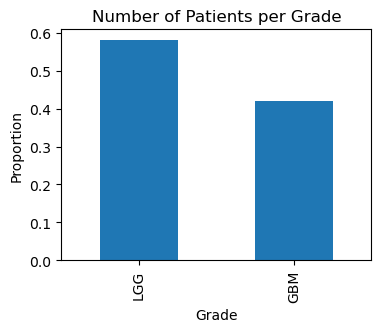

In [50]:
# Visualize the breakdown of patients per grade.
print(df['Grade'].value_counts())
plt.figure(figsize=(4,3))
df['Grade'].value_counts(normalize=True).plot(kind='bar', xlabel='Grade', ylabel='Proportion', title='Number of Patients per Grade')

Primary_Diagnosis
Glioblastoma                     360
Astrocytoma, anaplastic          129
Mixed glioma                     128
Oligodendroglioma, NOS           107
Oligodendroglioma, anaplastic     75
Astrocytoma, NOS                  58
Name: count, dtype: int64


<Axes: title={'center': 'Number of Patients per Primary Diagnosis'}, xlabel='Primary Diagnosis', ylabel='Proportion'>

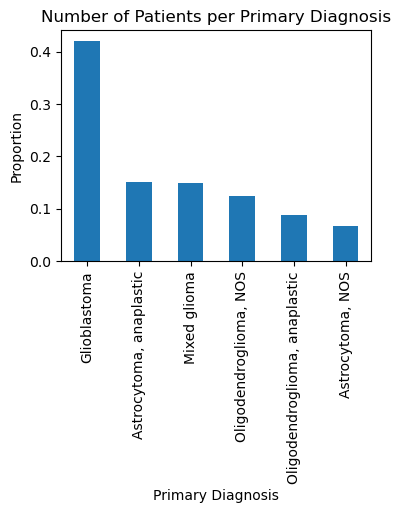

In [51]:
# Visualize the breakdown of patients per primary diagnosis.
print(df['Primary_Diagnosis'].value_counts())
plt.figure(figsize=(4,3))
df['Primary_Diagnosis'].value_counts(normalize=True).plot(kind='bar', xlabel='Primary Diagnosis', ylabel='Proportion', title='Number of Patients per Primary Diagnosis')

## Creating numerical Age and Feature sets
The Age_at_diagnosis feature is converted to a floating point value of years.

In [52]:
def convert_age(ageStr):
    lst = ageStr.split(" ")
    if len(lst) == 2: age = int(lst[0])
    if len(lst) == 4: age = int(lst[0]) + int(lst[2])/365
    return age

df['Age'] = df['Age_at_diagnosis'].apply(lambda x: convert_age(x))

The feature set is formed by removing the project information and the labels.

In [53]:
df_X = df.drop(['Grade', 'Project', 'Case_ID', 'Age_at_diagnosis', 'Primary_Diagnosis'], axis=1)
df_X.head()

,Gender,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Age
444,Male,black or african american,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,61.060274
316,Female,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,52.172603
415,Male,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,39.832877
6,Female,white,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,35.186301
382,Male,asian,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,34.438356


A second feature set is created with just the mutated gene data and the demographic data removed (gender, race, age).

In [54]:
# Convert all features except Age to categorical
# Change all 'object' columns type 'category'
df_X[df_X.select_dtypes(['object']).columns] = df_X.select_dtypes(['object']).apply(lambda x: x.astype('category'))
df_X2 = df_X.drop(['Gender', 'Race', 'Age'], axis=1)
df_X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 857 entries, 444 to 662
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   IDH1     857 non-null    category
 1   TP53     857 non-null    category
 2   ATRX     857 non-null    category
 3   PTEN     857 non-null    category
 4   EGFR     857 non-null    category
 5   CIC      857 non-null    category
 6   MUC16    857 non-null    category
 7   PIK3CA   857 non-null    category
 8   NF1      857 non-null    category
 9   PIK3R1   857 non-null    category
 10  FUBP1    857 non-null    category
 11  RB1      857 non-null    category
 12  NOTCH1   857 non-null    category
 13  BCOR     857 non-null    category
 14  CSMD3    857 non-null    category
 15  SMARCA4  857 non-null    category
 16  GRIN2A   857 non-null    category
 17  IDH2     857 non-null    category
 18  FAT4     857 non-null    category
 19  PDGFRA   857 non-null    category
dtypes: category(20)
memory usage: 58.1 

## Feature Scaling and Encoding
To assist wtih model building, the demographic data and the boolean gene mutation features are encoded and the age is scaled.  This process creates many additional "dummy" features, so the shape expands to 48 features.

In [55]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

catCols = df_X.select_dtypes("category").columns
catCols = list(set(catCols))
numCols = ['Age']
ct = make_column_transformer(
    (OneHotEncoder(), catCols),
    (StandardScaler(), numCols))
df_X_encoded = ct.fit_transform(df_X)
df_X_encoded.shape

(857, 48)

In [56]:
catCols = df_X2.select_dtypes("category").columns
catCols = list(set(catCols))
ct = make_column_transformer(
    (OneHotEncoder(), catCols))
df_X2_encoded = ct.fit_transform(df_X2)
df_X2_encoded.shape

(857, 40)

In [57]:
pd.DataFrame(df_X_encoded).head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.644623
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.079379
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.705410
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.000926
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.048494


# Building and Optimizing Models
## Principal Component Analysis
Here is an initial view with a feature reduction to two components.  The data appears to have four banded clusters.  However, the separation of points by the LGG/GBM grade follows the opposite axis.

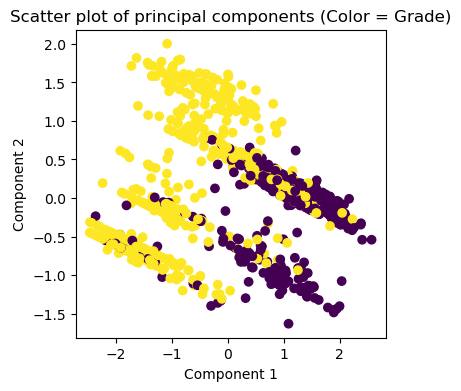

In [58]:
principal_2pc = PCA(n_components = 2)
principal_2pc.fit(df_X_encoded)
df_Xscaled2 = principal_2pc.transform(df_X_encoded)  # Result: 2 dimension array with 64 rows
plt.figure(figsize=(4,4))
plt.scatter(df_Xscaled2[:,0], df_Xscaled2[:,1], c=df_labels.gradeID)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Scatter plot of principal components (Color = Grade)")
plt.show()

## Optimization of PCA with Explained Variance Target
The following code and graph show that only about half of the components are explaining some of the variance.  A cut-off of 90% was used for the explained variance target leading to a selection of 14 components.

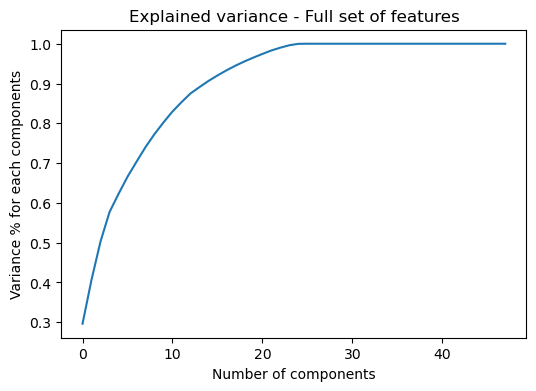

In [59]:
principal = PCA()
principal.fit(df_X_encoded)
df_X_PCA = principal.transform(df_X_encoded)

#plotting the cumulative summation of the explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(principal.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance - Full set of features')
plt.show()

In [60]:
explained_target = 0.9 # % of variance explained by PCA
pca_index = np.where(np.cumsum(principal.explained_variance_ratio_) > explained_target)[0][0]
print("Number of PCA components to use:", pca_index)
finalPCA = PCA(n_components = pca_index)
finalPCA.fit(df_X_encoded)
X_pca = finalPCA.transform(df_X_encoded)

Number of PCA components to use: 14


## Finding the "elbow" for k-Means clustering
The following graph shows that a sizeable drop in the sum of squared distances occurs when moving to two clusters.  A somewhat less drop occurs with three clusters, and then the drop starts flattening out.

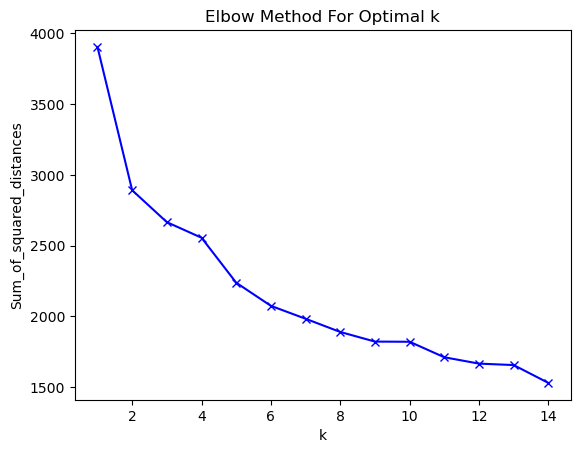

In [61]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=1000)
    km = km.fit(X_pca)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The following set of graphs show how the samples are grouped into 2, 3, 4, and 6 clusters.  Beyond two clusters, there is significant overlap between the clusters.

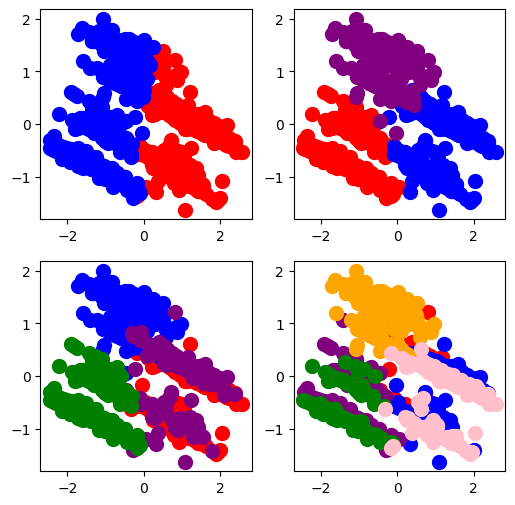

In [62]:
def plot_kmeans_clusters(n_clusters, myPlt):
    kmeans_plot = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
    y_kmeans=kmeans_plot.labels_
    myPlt.scatter(X_pca[y_kmeans==0,0],X_pca[y_kmeans==0,1],s=100,c='red',label='Cluster1')
    if n_clusters > 1: myPlt.scatter(X_pca[y_kmeans==1,0],X_pca[y_kmeans==1,1],s=100,c='blue',label='Cluster2')
    if n_clusters > 2: myPlt.scatter(X_pca[y_kmeans==2,0],X_pca[y_kmeans==2,1],s=100,c='purple',label='Cluster3')
    if n_clusters > 3: myPlt.scatter(X_pca[y_kmeans==3,0],X_pca[y_kmeans==3,1],s=100,c='green',label='Cluster4')
    if n_clusters > 4: myPlt.scatter(X_pca[y_kmeans==4,0],X_pca[y_kmeans==4,1],s=100,c='orange',label='Cluster5')
    if n_clusters > 5: myPlt.scatter(X_pca[y_kmeans==5,0],X_pca[y_kmeans==5,1],s=100,c='pink',label='Cluster5')
    #myPlt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroids')
    #myPlt.set_title(str.join(n_clusters, 'Clusters of data'))

fig=plt.figure(figsize=[6,6])
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)
plot_kmeans_clusters(2, ax0)
plot_kmeans_clusters(3, ax1)
plot_kmeans_clusters(4, ax2)
plot_kmeans_clusters(6, ax3)


## Back to Building Models
The reduced feature set (without demographic data) is run through PCA to determine how many features could be further reduced.

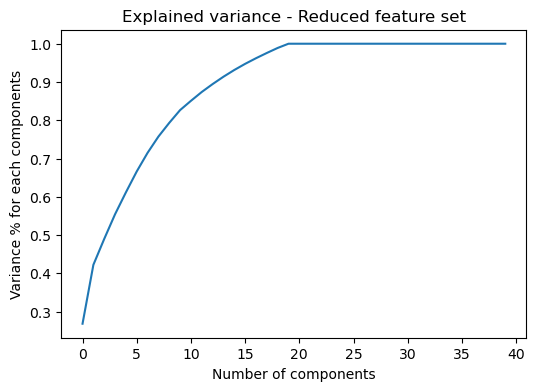

In [63]:
principal2 = PCA()
principal2.fit(df_X2_encoded)
df_X2_PCA = principal2.transform(df_X2_encoded)

#plotting the cumulative summation of the explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(principal2.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance - Reduced feature set')
plt.show()

In [64]:
pca_index = np.where(np.cumsum(principal2.explained_variance_ratio_) > explained_target)[0][0]
print("Number of PCA components to use:", pca_index)
finalPCA2 = PCA(n_components = pca_index)
finalPCA2.fit(df_X2_encoded)
X2_pca = finalPCA2.transform(df_X2_encoded)

Number of PCA components to use: 13


## Helper functions for model testing

In [65]:
# Need to map the model's category IDs back to the original category IDs
def label_permute_compare(yt, yp, n=6):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order, accuracy, chosen predicted labels. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # yt is the true labels, yp is what the model came up with (predictions)
    bestOrder = 0
    bestAccuracy = 0
    bestYP = 0
    # Save off the total number of samples for the denominator later on
    numSamples = yt.shape[0]
    #print("numSamples:", numSamples)
    # Compute how many permutations there are
    perms = itertools.permutations(range(n)) # Returns: (0, 1, 2, 3, 4), (0, 1, 2, 4, 3), (0, 1, 3, 2, 4)...
    for perm in perms:
        #print("perm:", perm)
        tmpYP=[]
        for i in range(numSamples):
            if yp[i] < 0:
                #print("Warning: negative yp[i]")
                pass
            elif yp[i] > n:
                #print("yp[i] too high:", yp[i])
                pass
            else:
                tmpYP.append(perm[yp[i]])
        acc = accuracy_score(yt, tmpYP)
        #print("acc:", acc)
        if acc > bestAccuracy:
            bestAccuracy = acc
            bestOrder = perm
            bestYP = tmpYP
    #print("Best order:", bestOrder, "Best accuracy:", bestAccuracy)
    return bestOrder, bestAccuracy, bestYP

In [66]:
def compare_and_cm(trueLabels, trueIDs, predIDs, label_names, n_clusters, showCM, headLines=0):
    # trueLabels = df_labels.Grade
    # trueIDs = df_labels.gradeID
    # predIDs = y_kmeans or kmeans.labels_
    # label_names = grade_names
    labelorder, acc, bestYP = label_permute_compare(trueIDs, predIDs, n_clusters)
    print(labelorder, acc)
    if headLines > 0:
        print(pd.DataFrame(data = {'true': trueLabels, 'trueID':trueIDs, 'pred':label_names[bestYP], 'predID':predIDs}).head(headLines))
    if showCM == True:
        cm = confusion_matrix(trueLabels, label_names[bestYP])
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, cmap='Greens', annot=True, fmt='.0f', xticklabels = label_names, yticklabels = label_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Categories")
        plt.ylabel("Actual Categories")

The k-Means, Mini Batch k-Means, Agglomerative Clustering, and Birch methods are dimension reduction techniques and so don't natively have a scoring function.

In [67]:
# Create a custom scoring function for dimension reduction
# See https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
# estimator is the model that should be evaluated, X is validation data, and y is the ground truth target for X (in the supervised case)
def DR_scoring(estimator, X, y):
    preds = estimator.labels_
    labelorder, acc, bestYP = label_permute_compare(y, preds, 6)
    return acc

## Clustering by Grade
A series of models are created and tested to see how accurately they can predict the LGG / GBM grade.  The series includes k-Means, Agglomerative, Birch, and Mini Batch k-Means.  Each of these was tested with a basic, initial configuration and cross-validated using the DB_scoring() function above.  These methods were attempted to be optimized using GridSearchCV.

Note: An attempt was made to utilize DBSCAN clustering.  However, it does not allow for a number of clusters to be pre-specified and was thus abandoned.
### Using K-Means

(0, 1) 0.8261376896149358
Cross validation mean accuracy: 0.5414 with std: 0.0262    All scores: [0.5523 0.5523 0.5146 0.5789 0.5088]


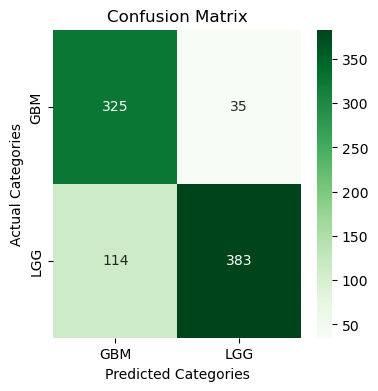

In [68]:
compResults = pd.DataFrame(columns = ['Method', 'CrossVal Mean Accuracy'])

if useOnlyLGG == False:
    n_clusters = num_grades
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
    compare_and_cm(df_labels.Grade, df_labels.gradeID, kmeans.labels_, grade_names, n_clusters, True)
    scores = cross_val_score(kmeans, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
    scores = np.round(scores, 4)
    print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
    compResults.at[0, 'Method'] = 'k-Means'
    compResults.at[0, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

else:
    print("Only examining LGG patients")

### By Grade:  Using Agglomerative Clustering

(1, 0) 0.8599766627771295
Cross validation mean accuracy: 0.5414 with std: 0.0241    All scores: [0.5407 0.5698 0.5146 0.5673 0.5146]


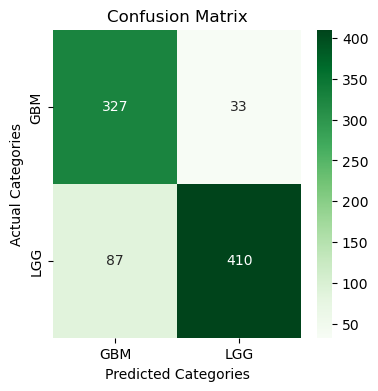

In [69]:
n_clusters = num_grades
aggC = AgglomerativeClustering(n_clusters = n_clusters, metric='euclidean', linkage='ward').fit(X_pca)
compare_and_cm(df_labels.Grade, df_labels.gradeID, aggC.labels_, grade_names, n_clusters, True)
scores = cross_val_score(aggC, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
compResults.at[1, 'Method'] = 'Agglomerative'
compResults.at[1, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

### Grid Search to Optimize Agglomerative Clustering

In [70]:
n_clusters = num_grades
aggC = AgglomerativeClustering(n_clusters = n_clusters)
search_parms = [{
    'linkage': ['complete', 'average', 'single'],
    'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
}]

gscv_AC = GridSearchCV(estimator=aggC, param_grid = search_parms, scoring = DR_scoring, cv=5, verbose=0)
startTime = time.time()
gscv_AC.fit(X_pca, df_labels.gradeID)
print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")

Execution time: 0.7 minutes


In [71]:
results = (pd.DataFrame(gscv_AC.cv_results_))[['params', 'mean_test_score', 'rank_test_score']].copy()
print(tabulate(results.sort_values(by='rank_test_score').iloc[:5,:], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[60, None, None]))
compResults.at[2, 'Method'] = 'Optimized Agglomerative'
compResults.at[2, 'CrossVal Mean Accuracy'] = np.round(results.sort_values(by='rank_test_score').iloc[0,1], 4)

╭──────────────────────────────────────────────┬───────────────────┬───────────────────╮
│ params                                       │   mean_test_score │   rank_test_score │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'euclidean'} │          0.579974 │                 1 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'l1'}        │          0.579974 │                 1 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'l2'}        │          0.579974 │                 1 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'manhattan'} │          0.579974 │                 1 │
├──────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'averag

### DBSCAN for Grade Clustering

In [72]:
# NOTE: DBSCAN does not allow for the number of clusters to be specified, so it doesn't work for this application
#n_clusters = num_grades
#dbscan = DBSCAN(eps=1.405, min_samples=5, algorithm='ball_tree').fit(X_pca)
#print(pd.DataFrame(dbscan.labels_).describe())
#compare_and_cm(df_labels.Grade, df_labels.gradeID, dbscan.labels_, grade_names, n_clusters, True)
#scores = cross_val_score(dbscan, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
#print("Cross validation mean accuracy:", np.mean(scores))

### Birch for Grade Clustering

(1, 0) 0.851808634772462
Cross validation mean accuracy: 0.5425 with std: 0.0381    All scores: [0.5581 0.6047 0.5029 0.5439 0.5029]


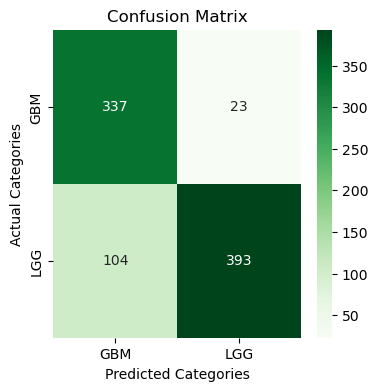

In [73]:
n_clusters = num_grades
brc = Birch(n_clusters = n_clusters).fit(X_pca)
compare_and_cm(df_labels.Grade, df_labels.gradeID, brc.labels_, grade_names, n_clusters, True)
scores = cross_val_score(brc, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
compResults.at[3, 'Method'] = 'Birch'
compResults.at[3, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

### Mini Batch k-Means for Grade Clustering

(1, 0) 0.7899649941656943
Cross validation mean accuracy: 0.5426 with std: 0.0406    All scores: [0.5581 0.5291 0.5029 0.614  0.5088]


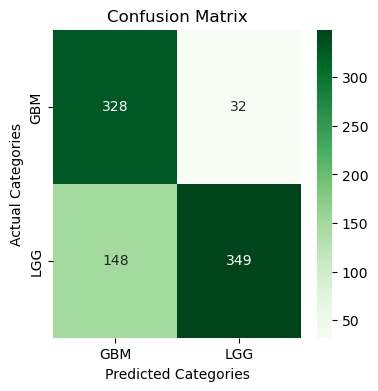

In [74]:
n_clusters = num_grades
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", max_iter=1000, batch_size=100, n_init=10, reassignment_ratio=0.1).fit(X_pca)
compare_and_cm(df_labels.Grade, df_labels.gradeID, kmeans.labels_, grade_names, n_clusters, True)
scores = cross_val_score(kmeans, X_pca, df_labels.gradeID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
compResults.at[4, 'Method'] = 'Mini Batch k-Means'
compResults.at[4, 'CrossVal Mean Accuracy'] = np.round(np.mean(scores), 4)

### Grid Search to Optimize Mini Batch k-Means

In [75]:
n_clusters = num_grades
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", max_iter=1000, batch_size=100, n_init=10, reassignment_ratio=0.1).fit(X_pca)
search_parms = [{
    'max_iter': [100, 1000, 5000],
    'batch_size' : [10, 100, 1000],
    'n_init' : [10, 100],
    'reassignment_ratio' : [0.01, 0.05, 0.1],
}]

gscv_MB = GridSearchCV(estimator=kmeans, param_grid = search_parms, scoring = DR_scoring, cv=5, verbose=0)
startTime = time.time()
gscv_MB.fit(X_pca, df_labels.gradeID)
print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")

Execution time: 2.9 minutes


In [76]:
results = (pd.DataFrame(gscv_MB.cv_results_))[['params', 'mean_test_score', 'rank_test_score']].copy()
print(tabulate(results.sort_values(by='rank_test_score').iloc[:5,:], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[80, None, None]))
compResults.at[5, 'Method'] = 'Optimized Mini Batch k-Means'
compResults.at[5, 'CrossVal Mean Accuracy'] = np.round(results.sort_values(by='rank_test_score').iloc[0,1], 4)

╭──────────────────────────────────────────────────────────────────────────────────┬───────────────────┬───────────────────╮
│ params                                                                           │   mean_test_score │   rank_test_score │
├──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'batch_size': 100, 'max_iter': 1000, 'n_init': 100, 'reassignment_ratio': 0.05} │          0.551897 │                 1 │
├──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'batch_size': 1000, 'max_iter': 100, 'n_init': 100, 'reassignment_ratio': 0.05} │          0.550734 │                 2 │
├──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'batch_size': 10, 'max_iter': 5000, 'n_init': 100, 'reassignment_ratio': 0.05}  │          0.548436 │                 3 │


## Summary of Clustering for Grade
None of the models were able to achieve an acceptable level of accuracy.  Most were around 55% which is almost to same as pure guessing.  It should be noted that some runs had accuracy levels greater than 85% but this was probably due to random chance.

In [77]:
print(tabulate(compResults, headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[None, None]))

╭──────────────────────────────┬──────────────────────────╮
│ Method                       │   CrossVal Mean Accuracy │
├──────────────────────────────┼──────────────────────────┤
│ k-Means                      │                   0.5414 │
├──────────────────────────────┼──────────────────────────┤
│ Agglomerative                │                   0.5414 │
├──────────────────────────────┼──────────────────────────┤
│ Optimized Agglomerative      │                   0.58   │
├──────────────────────────────┼──────────────────────────┤
│ Birch                        │                   0.5425 │
├──────────────────────────────┼──────────────────────────┤
│ Mini Batch k-Means           │                   0.5426 │
├──────────────────────────────┼──────────────────────────┤
│ Optimized Mini Batch k-Means │                   0.5519 │
╰──────────────────────────────┴──────────────────────────╯


## Clustering by Primary Diagnosis
Given the poor performance in clustering around the LGG/GBM grade, there isn't a lot of hope that the models will do better for the Primary Diagnosis.  Indeed, with k-Means, the cross validation acccuracy is 32% and the optimized Agglomerative Clustering score is 42%.
### Using K-Means

(3, 2, 0, 5, 4, 1) 0.3943990665110852
Cross validation mean accuracy: 0.2578 with std: 0.0429    All scores: [0.2151 0.3372 0.2632 0.2281 0.2456]


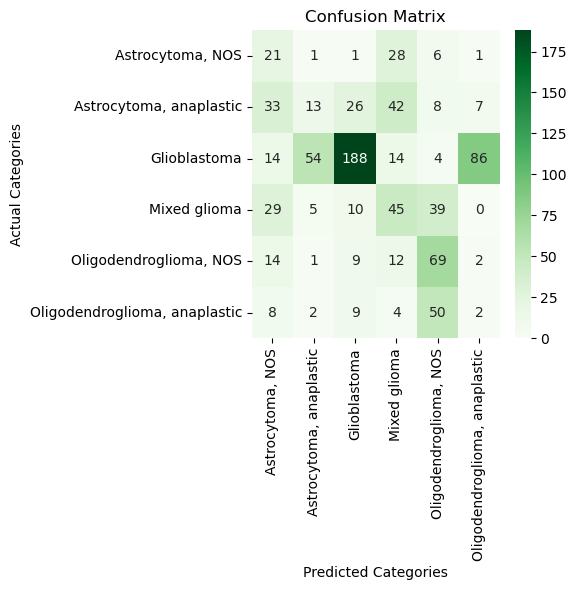

In [78]:
n_clusters = num_primary_diags
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
compare_and_cm(df_labels.Primary_Diagnosis, df_labels.diagID, kmeans.labels_, diag_names, n_clusters, True)
scores = cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring)
scores = np.round(scores, 4)
print("Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)

### Comparing performance of k-Means using various X datasets

In [79]:
n_clusters = num_primary_diags
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(df_X_encoded)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("df_X_encoded:  Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X_pca)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("X_pca:         Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(df_X2_encoded)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("df_X2_encoded: Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(X2_pca)
scores = np.round(cross_val_score(kmeans, X_pca, df_labels.diagID, cv=5, scoring=DR_scoring), 4)
print("X2_pca:        Cross validation mean accuracy:", np.round(np.mean(scores), 4), "with std:", np.round(np.std(scores), 4), "   All scores:", scores)

df_X_encoded:  Cross validation mean accuracy: 0.2544 with std: 0.0204    All scores: [0.2209 0.2849 0.2515 0.2573 0.2573]
X_pca:         Cross validation mean accuracy: 0.2462 with std: 0.0234    All scores: [0.2326 0.2849 0.2573 0.2398 0.2164]
df_X2_encoded: Cross validation mean accuracy: 0.2566 with std: 0.0242    All scores: [0.2616 0.2965 0.2456 0.2222 0.2573]
X2_pca:        Cross validation mean accuracy: 0.2823 with std: 0.034    All scores: [0.3023 0.3372 0.2515 0.2749 0.2456]


### Grid Search Optimization of Agglomerative Clustering for Primary Diagnosis

In [80]:
n_clusters = num_primary_diags
aggC = AgglomerativeClustering(n_clusters = n_clusters)
search_parms = [{
    'linkage': ['complete', 'average', 'single'],
    'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
}]

gscv = GridSearchCV(estimator=aggC, param_grid = search_parms, scoring = DR_scoring, cv=5, verbose=0)
startTime = time.time()
gscv.fit(X_pca, df_labels.diagID)
print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")

Execution time: 0.7 minutes


In [81]:
results = (pd.DataFrame(gscv.cv_results_))[['params', 'mean_test_score', 'rank_test_score']].copy()
print(tabulate(results.sort_values(by='rank_test_score').iloc[:5,:], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[60, None, None]))

╭───────────────────────────────────────────────┬───────────────────┬───────────────────╮
│ params                                        │   mean_test_score │   rank_test_score │
├───────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'average', 'metric': 'l1'}        │          0.427016 │                 1 │
├───────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'average', 'metric': 'manhattan'} │          0.427016 │                 1 │
├───────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'euclidean'}  │          0.424697 │                 3 │
├───────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkage': 'single', 'metric': 'l1'}         │          0.424697 │                 3 │
├───────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ {'linkag

# Comparison with Supervised Learning
The following supervised learning models will be employed to attempt to cluster by LGG/GBM grade:  Logistic Regression, Linear Support Vector Classifier, Stochastic Gradient Descent (SGD) Classifier

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

## Classifying according to Grade

In [83]:
supervised_X = X2_pca # X_pca
def run_model(model):
    model.fit(supervised_X, df_labels.Grade)
    y_pred = model.predict(supervised_X)
    acc = accuracy_score(df_labels.Grade, y_pred)
    scores = cross_val_score(model, X = supervised_X, y = df_labels.Grade, scoring='accuracy', cv=5)
    return round(acc, 4), np.round(scores, 4)

lsvm_model = LinearSVC(dual=False, C = 1, loss = 'squared_hinge', max_iter=5000)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
sgdc = SGDClassifier(penalty='elasticnet', max_iter=1000, tol=1e-3)

startTime = time.time()
reduced_results = pd.DataFrame(columns = ['Method', 'Mean Accuracy', 'CrossVal Mean Accuracy', 'CrossVal Std Accuracy'])
acc, scores = run_model(lsvm_model)
reduced_results.at[0, 'Method'] = 'LinearSVC'
reduced_results.at[0, 'Mean Accuracy'] = acc
reduced_results.at[0, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[0, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(logreg)
reduced_results.at[1, 'Method'] = 'Logistic Regression'
reduced_results.at[1, 'Mean Accuracy'] = acc
reduced_results.at[1, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[1, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(sgdc)
reduced_results.at[2, 'Method'] = 'SGD Classification'
reduced_results.at[2, 'Mean Accuracy'] = acc
reduced_results.at[2, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[2, 'CrossVal Std Accuracy'] = np.std(scores)

print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")
print("\nSupervised Learning classification according to LGG/GBM Grade")
from tabulate import tabulate  #  See https://pypi.org/project/tabulate/
print(tabulate(reduced_results.sort_values(['Method'], ascending=[True]), 
               headers='keys', tablefmt='rounded_grid', showindex=False))

Execution time: 0.0 minutes

Supervised Learning classification according to LGG/GBM Grade
╭─────────────────────┬─────────────────┬──────────────────────────┬─────────────────────────╮
│ Method              │   Mean Accuracy │   CrossVal Mean Accuracy │   CrossVal Std Accuracy │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ LinearSVC           │          0.8588 │                  0.85646 │               0.026085  │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ Logistic Regression │          0.8623 │                  0.85994 │               0.0248506 │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ SGD Classification  │          0.8611 │                  0.84946 │               0.0188606 │
╰─────────────────────┴─────────────────┴──────────────────────────┴─────────────────────────╯


## Classifying according to Primary Diagnosis

In [84]:
supervised_X = X_pca # X_pca
def run_model(model):
    model.fit(supervised_X, df_labels.Primary_Diagnosis)
    y_pred = model.predict(supervised_X)
    acc = accuracy_score(df_labels.Primary_Diagnosis, y_pred)
    scores = cross_val_score(model, X = supervised_X, y = df_labels.Primary_Diagnosis, scoring='accuracy', cv=5)
    return round(acc, 4), np.round(scores, 4)

lsvm_model = LinearSVC(dual=False, C = 1, loss = 'squared_hinge', max_iter=5000)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
sgdc = SGDClassifier(penalty='elasticnet', max_iter=1000, tol=1e-3)

startTime = time.time()
reduced_results = pd.DataFrame(columns = ['Method', 'Mean Accuracy', 'CrossVal Mean Accuracy', 'CrossVal Std Accuracy'])
acc, scores = run_model(lsvm_model)
reduced_results.at[0, 'Method'] = 'LinearSVC'
reduced_results.at[0, 'Mean Accuracy'] = acc
reduced_results.at[0, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[0, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(logreg)
reduced_results.at[1, 'Method'] = 'Logistic Regression'
reduced_results.at[1, 'Mean Accuracy'] = acc
reduced_results.at[1, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[1, 'CrossVal Std Accuracy'] = np.std(scores)
acc, scores = run_model(sgdc)
reduced_results.at[2, 'Method'] = 'SGD Classification'
reduced_results.at[2, 'Mean Accuracy'] = acc
reduced_results.at[2, 'CrossVal Mean Accuracy'] = np.mean(scores)
reduced_results.at[2, 'CrossVal Std Accuracy'] = np.std(scores)

print("Execution time:", round((time.time() - startTime)/60, 1), "minutes")
from tabulate import tabulate  #  See https://pypi.org/project/tabulate/
print("\nSupervised Learning classification according to Primary Diagnosis")
print(tabulate(reduced_results.sort_values(['Method'], ascending=[True]), 
               headers='keys', tablefmt='rounded_grid', showindex=False))

Execution time: 0.0 minutes

Supervised Learning classification according to Primary Diagnosis
╭─────────────────────┬─────────────────┬──────────────────────────┬─────────────────────────╮
│ Method              │   Mean Accuracy │   CrossVal Mean Accuracy │   CrossVal Std Accuracy │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ LinearSVC           │          0.5741 │                  0.54258 │               0.017953  │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ Logistic Regression │          0.5858 │                  0.56006 │               0.0310109 │
├─────────────────────┼─────────────────┼──────────────────────────┼─────────────────────────┤
│ SGD Classification  │          0.5298 │                  0.50992 │               0.0194387 │
╰─────────────────────┴─────────────────┴──────────────────────────┴─────────────────────────╯


# Conclusion
The unsupervised learning methods for clustering included k-Means, Agglomerative, Birch, and Mini Batch k-Means.  None of these methods performed well in discerning the differences between the LGG and GBM grades.  All methods were around 55% accurate.  They performed equally poorly on the Primary Diagnosis labels.  On the other hand, the supervised learning techniques, which included Linear SVC, Logistic Regression, and SGD Classification, all performed reasonably well at about 85% accuracy.

A few notes and insights:
- No attempt was made to optimized the supervised learning models through hyper-parameter tuning.  It is concievable that the accuracy scores could be improved from what is seen here.
- There was little difference in unsupervised learning model performance in regard to operating on data that had been reduced with PCA or not.  That is, dimension reduction using PCA, did not improve final model performance.
- There was little difference in supervised learning model performance in regard to including the demographic data (gender, race, age).
- The supervised learning models had an accuracy of only 50 to 60% for Primary Diagnosis.  Note that the Primary Diagnosis has six labels.